# %% [markdown]
# # 📊 VIX Data Analysis - Análisis Completo
# 

# ## Contenido:
# 1. Carga y exploración de datos
# 2. Análisis estadístico descriptivo
# 3. Visualizaciones principales
# 4. Análisis técnico
# 5. Análisis temporal y estacional
# 6. Correlaciones y relaciones
# 7. Detección de anomalías
# 8. Preparación para dashboards
# 9. Exportación de resultados

In [4]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

In [5]:
# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de análisis: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

✅ Librerías importadas correctamente
📅 Fecha de análisis: 2025-05-25 14:26


In [7]:
# Cargar datos desde el archivo CSV
def load_vix_data(filepath='static/data/vix_data_enricher.csv'):
    """
    Carga los datos del VIX desde el archivo CSV enriquecido
    """
    try:
        # Cargar datos con manejo de decimales
        df = pd.read_csv(filepath, decimal=',')
        
        # Convertir fecha a datetime
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Ordenar por fecha
        df = df.sort_values('Date').reset_index(drop=True)
        
        print(f"✅ Datos cargados exitosamente")
        print(f"📊 Shape: {df.shape}")
        print(f"📅 Período: {df['Date'].min().date()} a {df['Date'].max().date()}")
        print(f"📈 Días de datos: {len(df)}")
        
        return df
        
    except FileNotFoundError:
        print("❌ Error: No se encontró el archivo vix_data_enricher.csv")
        print("   Asegúrate de haber ejecutado el pipeline ETL primero")
        return None
    except Exception as e:
        print(f"❌ Error al cargar datos: {e}")
        return None

# Cargar los datos
df = load_vix_data()

if df is None:
    print("\n⚠️ No se pudieron cargar los datos. Ejecuta primero:")
    print("   python main.py --mode full")
else:
    print("\n✅ Datos cargados correctamente")

✅ Datos cargados exitosamente
📊 Shape: (251, 86)
📅 Período: 2024-05-23 a 2025-05-23
📈 Días de datos: 251

✅ Datos cargados correctamente


In [8]:
# Exploración inicial de los datos
if df is not None:
    print("📋 INFORMACIÓN DEL DATASET:")
    print("="*50)
    
    # Información básica
    print(f"\n1. DIMENSIONES:")
    print(f"   - Filas (días): {len(df):,}")
    print(f"   - Columnas (features): {len(df.columns)}")
    
    # Tipos de datos
    print(f"\n2. TIPOS DE DATOS:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   - {dtype}: {count} columnas")
    
    # Valores faltantes
    print(f"\n3. VALORES FALTANTES:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100)
    missing_summary = pd.DataFrame({
        'Columna': missing.index,
        'Faltantes': missing.values,
        'Porcentaje': missing_pct.values
    })
    missing_summary = missing_summary[missing_summary['Faltantes'] > 0].sort_values('Porcentaje', ascending=False)
    
    if len(missing_summary) > 0:
        print(missing_summary.head(10))
    else:
        print("   ✅ No hay valores faltantes")
    
    # Columnas disponibles
    print(f"\n4. COLUMNAS DISPONIBLES:")
    print("   Datos básicos:")
    basic_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    print(f"   {[col for col in basic_cols if col in df.columns]}")
    
    print("\n   Indicadores técnicos:")
    tech_cols = ['MA5', 'MA10', 'MA20', 'MA50', 'RSI', 'MACD', 'ATR', 'BB_Upper', 'BB_Lower']
    available_tech = [col for col in tech_cols if col in df.columns]
    print(f"   {available_tech[:5]}...")
    
    print("\n   Variables temporales:")
    temp_cols = ['Year', 'Month', 'Quarter', 'DayOfWeek', 'WeekdayName', 'MonthName']
    available_temp = [col for col in temp_cols if col in df.columns]
    print(f"   {available_temp}")

📋 INFORMACIÓN DEL DATASET:

1. DIMENSIONES:
   - Filas (días): 251
   - Columnas (features): 86

2. TIPOS DE DATOS:
   - float64: 65 columnas
   - int64: 17 columnas
   - object: 4 columnas

3. VALORES FALTANTES:
                  Columna  Faltantes  Porcentaje
29                   MA50         49       19.52
82     VIX_Percentile_50d         49       19.52
56  VIX_SP500_Correlation         20        7.97
38               BB_Lower         19        7.57
39               BB_Width         19        7.57
40            BB_Position         19        7.57
37               BB_Upper         19        7.57
36              BB_Middle         19        7.57
34         Volatility_20d         19        7.57
81     VIX_Percentile_20d         19        7.57

4. COLUMNAS DISPONIBLES:
   Datos básicos:
   ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

   Indicadores técnicos:
   ['MA5', 'MA10', 'MA20', 'MA50', 'RSI']...

   Variables temporales:
   ['Year', 'Month', 'Quarter', 'DayOfWeek', 'Weekday

In [9]:
# ## 2. Análisis Estadístico Descriptivo

# %%
# Estadísticas descriptivas del VIX
if df is not None:
    print("📊 ESTADÍSTICAS DESCRIPTIVAS DEL VIX:")
    print("="*50)
    
    # Estadísticas básicas
    vix_stats = df['Close'].describe()
    print(f"\nValor actual: {df['Close'].iloc[-1]:.2f}")
    print(f"Promedio histórico: {vix_stats['mean']:.2f}")
    print(f"Mediana: {vix_stats['50%']:.2f}")
    print(f"Desviación estándar: {vix_stats['std']:.2f}")
    print(f"Mínimo histórico: {vix_stats['min']:.2f} (fecha: {df.loc[df['Close'].idxmin(), 'Date'].date()})")
    print(f"Máximo histórico: {vix_stats['max']:.2f} (fecha: {df.loc[df['Close'].idxmax(), 'Date'].date()})")
    
    # Percentiles importantes
    print(f"\nPERCENTILES:")
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        value = np.percentile(df['Close'].dropna(), p)
        print(f"   P{p}: {value:.2f}")
    
    # Análisis de cambios diarios
    if 'Daily_Change' in df.columns:
        print(f"\nCAMBIOS DIARIOS:")
        daily_stats = df['Daily_Change'].describe()
        print(f"   Promedio: {daily_stats['mean']:.2f}%")
        print(f"   Volatilidad de cambios: {daily_stats['std']:.2f}%")
        print(f"   Mayor subida: {daily_stats['max']:.2f}%")
        print(f"   Mayor caída: {daily_stats['min']:.2f}%")

📊 ESTADÍSTICAS DESCRIPTIVAS DEL VIX:

Valor actual: 22.29
Promedio histórico: 18.63
Mediana: 17.21
Desviación estándar: 5.96
Mínimo histórico: 11.93 (fecha: 2024-05-24)
Máximo histórico: 52.33 (fecha: 2025-04-08)

PERCENTILES:
   P10: 12.92
   P25: 14.93
   P50: 17.21
   P75: 20.58
   P90: 24.70
   P95: 29.84
   P99: 43.02

CAMBIOS DIARIOS:
   Promedio: 0.78%
   Volatilidad de cambios: 11.21%
   Mayor subida: 74.04%
   Mayor caída: -35.75%


📊 DISTRIBUCIÓN POR NIVELES DE VIX:
    Nivel  Días  Porcentaje  Promedio_VIX
0  Normal   149       59.36         27.55
1     Low    51       20.32         13.03
2    High    51       20.32         17.49


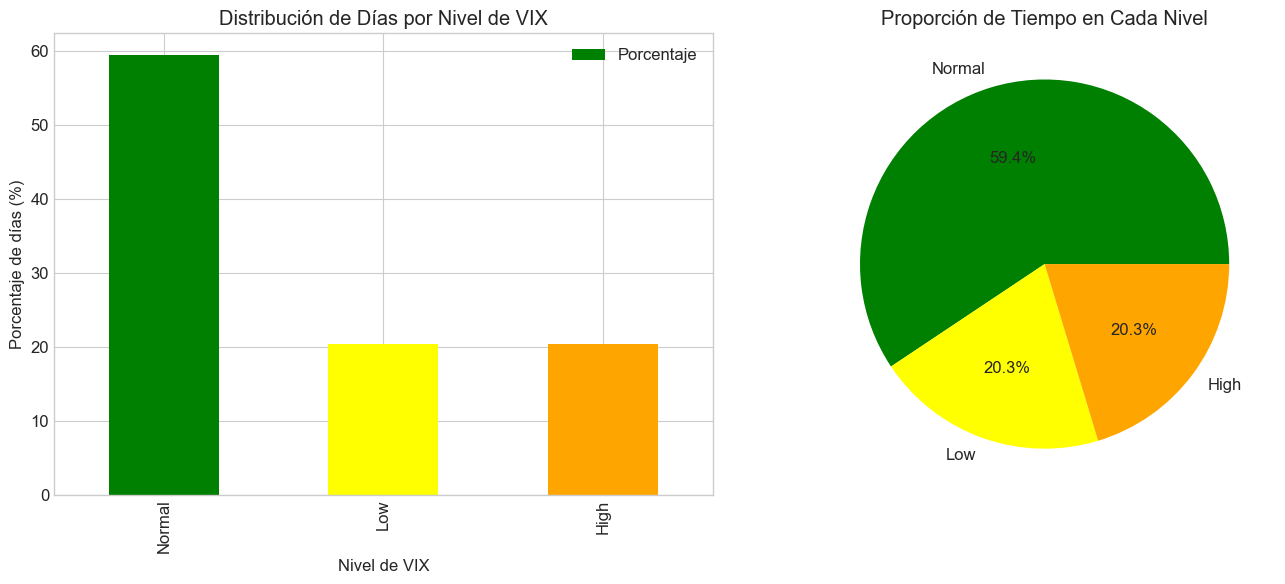

In [10]:
# Análisis por niveles de VIX
if df is not None and 'VIX_Level' in df.columns:
    print("📊 DISTRIBUCIÓN POR NIVELES DE VIX:")
    print("="*50)
    
    # Conteo por niveles
    level_counts = df['VIX_Level'].value_counts()
    level_pct = (level_counts / len(df) * 100).round(2)
    
    level_analysis = pd.DataFrame({
        'Nivel': level_counts.index,
        'Días': level_counts.values,
        'Porcentaje': level_pct.values,
        'Promedio_VIX': df.groupby('VIX_Level')['Close'].mean().values.round(2)
    })
    
    print(level_analysis)
    
    # Gráfico de distribución
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gráfico de barras
    level_analysis.plot(x='Nivel', y='Porcentaje', kind='bar', ax=ax1, 
                       color=['green', 'yellow', 'orange', 'red'])
    ax1.set_title('Distribución de Días por Nivel de VIX')
    ax1.set_ylabel('Porcentaje de días (%)')
    ax1.set_xlabel('Nivel de VIX')
    
    # Gráfico de pastel
    ax2.pie(level_counts.values, labels=level_counts.index, autopct='%1.1f%%',
            colors=['green', 'yellow', 'orange', 'red'])
    ax2.set_title('Proporción de Tiempo en Cada Nivel')
    
    plt.tight_layout()
    plt.show()

In [11]:
# ## 3. Visualizaciones Principales

# %%
# Gráfico principal del VIX con indicadores
if df is not None:
    # Crear figura con subplots
    fig = make_subplots(
        rows=4, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        row_heights=[0.4, 0.2, 0.2, 0.2],
        subplot_titles=('VIX con Medias Móviles y Bandas de Bollinger', 
                       'RSI (Índice de Fuerza Relativa)',
                       'MACD', 
                       'Volumen de Operaciones')
    )
    
    # Panel 1: VIX con medias móviles
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='VIX',
                            line=dict(color='blue', width=2)), row=1, col=1)
    
    if 'MA20' in df.columns:
        fig.add_trace(go.Scatter(x=df['Date'], y=df['MA20'], name='MA20',
                                line=dict(color='red', width=1)), row=1, col=1)
    
    if 'MA50' in df.columns:
        fig.add_trace(go.Scatter(x=df['Date'], y=df['MA50'], name='MA50',
                                line=dict(color='green', width=1)), row=1, col=1)
    
    # Bandas de Bollinger
    if all(col in df.columns for col in ['BB_Upper', 'BB_Lower']):
        fig.add_trace(go.Scatter(x=df['Date'], y=df['BB_Upper'], name='BB Superior',
                                line=dict(color='gray', width=1, dash='dash'),
                                showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=df['Date'], y=df['BB_Lower'], name='BB Inferior',
                                line=dict(color='gray', width=1, dash='dash'),
                                fill='tonexty', fillcolor='rgba(128,128,128,0.2)',
                                showlegend=False), row=1, col=1)
    
    # Panel 2: RSI
    if 'RSI' in df.columns:
        fig.add_trace(go.Scatter(x=df['Date'], y=df['RSI'], name='RSI',
                                line=dict(color='purple', width=2)), row=2, col=1)
        fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
        fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)
    
    # Panel 3: MACD
    if all(col in df.columns for col in ['MACD', 'MACD_Signal']):
        fig.add_trace(go.Scatter(x=df['Date'], y=df['MACD'], name='MACD',
                                line=dict(color='blue', width=1)), row=3, col=1)
        fig.add_trace(go.Scatter(x=df['Date'], y=df['MACD_Signal'], name='Señal',
                                line=dict(color='red', width=1)), row=3, col=1)
    
    # Panel 4: Volumen
    if 'Volume' in df.columns:
        fig.add_trace(go.Bar(x=df['Date'], y=df['Volume'], name='Volumen',
                            marker_color='lightblue'), row=4, col=1)
    
    # Actualizar diseño
    fig.update_layout(height=1000, title_text="📈 Análisis Técnico Completo del VIX")
    fig.update_xaxes(title_text="Fecha", row=4, col=1)
    fig.update_yaxes(title_text="VIX", row=1, col=1)
    fig.update_yaxes(title_text="RSI", row=2, col=1)
    fig.update_yaxes(title_text="MACD", row=3, col=1)
    fig.update_yaxes(title_text="Volumen", row=4, col=1)
    
    fig.show()

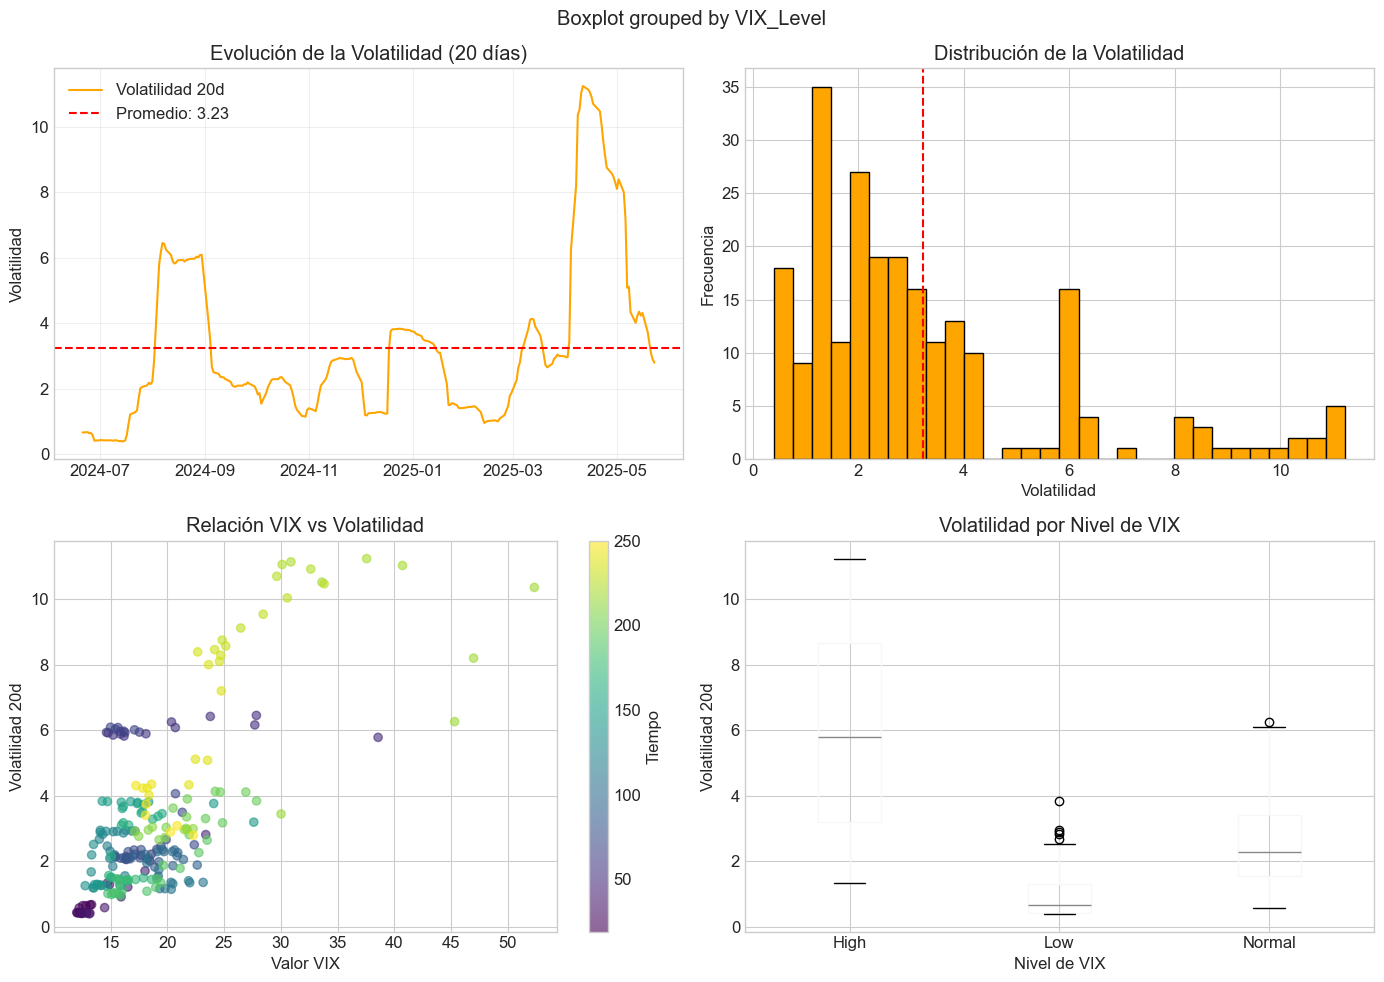


📊 ANÁLISIS DE VOLATILIDAD:
Volatilidad promedio: 3.23
Volatilidad actual: 2.79
Máxima volatilidad: 11.24
Mínima volatilidad: 0.39


In [12]:
# ## 4. Análisis de Volatilidad

# %%
# Análisis de volatilidad histórica
if df is not None and 'Volatility_20d' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Evolución de la volatilidad
    ax1 = axes[0, 0]
    ax1.plot(df['Date'], df['Volatility_20d'], label='Volatilidad 20d', color='orange')
    ax1.axhline(y=df['Volatility_20d'].mean(), color='red', linestyle='--', 
                label=f'Promedio: {df["Volatility_20d"].mean():.2f}')
    ax1.set_title('Evolución de la Volatilidad (20 días)')
    ax1.set_ylabel('Volatilidad')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribución de la volatilidad
    ax2 = axes[0, 1]
    df['Volatility_20d'].hist(bins=30, ax=ax2, color='orange', edgecolor='black')
    ax2.axvline(x=df['Volatility_20d'].mean(), color='red', linestyle='--')
    ax2.set_title('Distribución de la Volatilidad')
    ax2.set_xlabel('Volatilidad')
    ax2.set_ylabel('Frecuencia')
    
    # 3. Volatilidad vs VIX
    ax3 = axes[1, 0]
    scatter = ax3.scatter(df['Close'], df['Volatility_20d'], 
                         c=df.index, cmap='viridis', alpha=0.6)
    ax3.set_xlabel('Valor VIX')
    ax3.set_ylabel('Volatilidad 20d')
    ax3.set_title('Relación VIX vs Volatilidad')
    plt.colorbar(scatter, ax=ax3, label='Tiempo')
    
    # 4. Volatilidad por nivel de VIX
    if 'VIX_Level' in df.columns:
        ax4 = axes[1, 1]
        df.boxplot(column='Volatility_20d', by='VIX_Level', ax=ax4)
        ax4.set_title('Volatilidad por Nivel de VIX')
        ax4.set_xlabel('Nivel de VIX')
        ax4.set_ylabel('Volatilidad 20d')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de volatilidad
    print("\n📊 ANÁLISIS DE VOLATILIDAD:")
    print("="*50)
    print(f"Volatilidad promedio: {df['Volatility_20d'].mean():.2f}")
    print(f"Volatilidad actual: {df['Volatility_20d'].iloc[-1]:.2f}")
    print(f"Máxima volatilidad: {df['Volatility_20d'].max():.2f}")
    print(f"Mínima volatilidad: {df['Volatility_20d'].min():.2f}")

ValueError: Invalid color winter

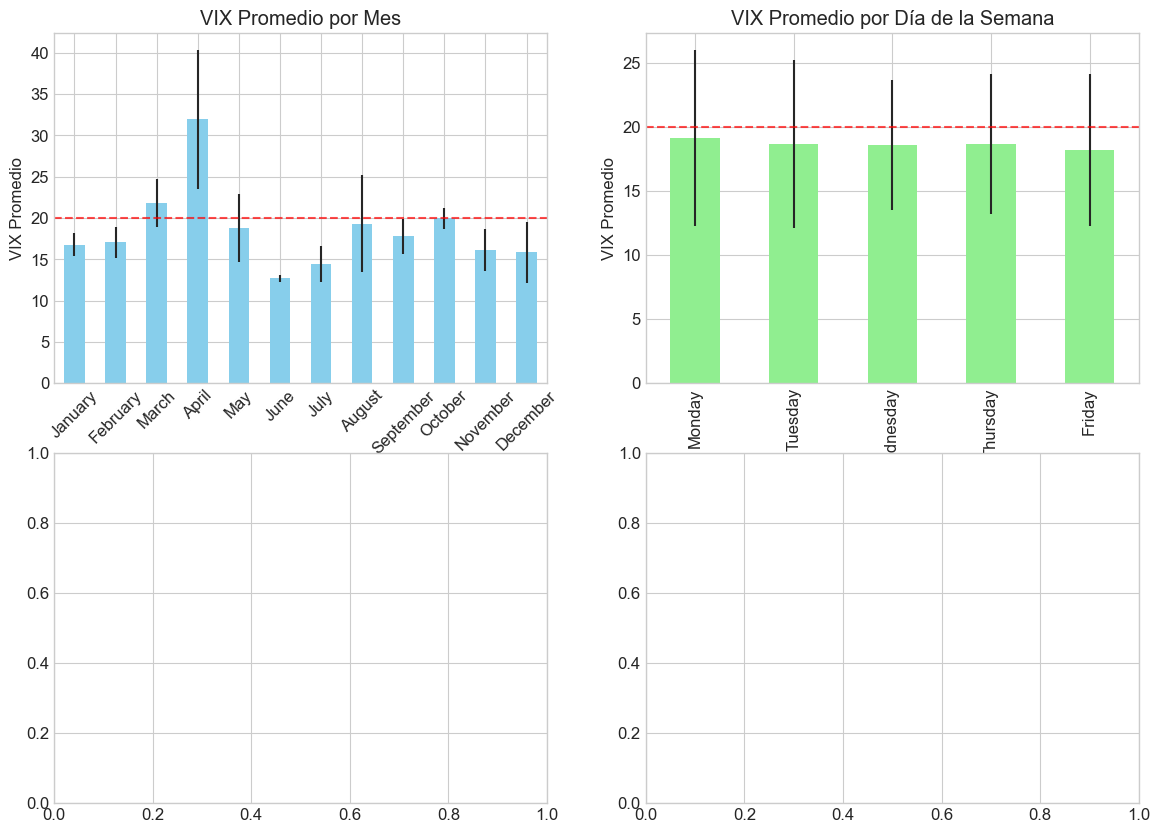

In [13]:
# ## 5. Análisis Temporal y Estacional

# %%
# Análisis por período temporal
if df is not None:
    # Preparar datos agregados
    monthly_avg = df.groupby('MonthName')['Close'].agg(['mean', 'std', 'count'])
    
    # Ordenar meses correctamente
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    monthly_avg = monthly_avg.reindex([m for m in month_order if m in monthly_avg.index])
    
    # Análisis por día de la semana
    weekly_avg = df.groupby('WeekdayName')['Close'].agg(['mean', 'std', 'count'])
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekly_avg = weekly_avg.reindex([d for d in day_order if d in weekly_avg.index])
    
    # Crear visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Promedio mensual
    ax1 = axes[0, 0]
    monthly_avg['mean'].plot(kind='bar', ax=ax1, color='skyblue', yerr=monthly_avg['std'])
    ax1.set_title('VIX Promedio por Mes')
    ax1.set_ylabel('VIX Promedio')
    ax1.axhline(y=20, color='red', linestyle='--', alpha=0.7)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
    # 2. Promedio por día de la semana
    ax2 = axes[0, 1]
    weekly_avg['mean'].plot(kind='bar', ax=ax2, color='lightgreen', yerr=weekly_avg['std'])
    ax2.set_title('VIX Promedio por Día de la Semana')
    ax2.set_ylabel('VIX Promedio')
    ax2.axhline(y=20, color='red', linestyle='--', alpha=0.7)
    
    # 3. Análisis por trimestre
    if 'Quarter' in df.columns:
        ax3 = axes[1, 0]
        quarterly_data = df.groupby('Quarter')['Close'].agg(['mean', 'std'])
        quarterly_data.plot(kind='bar', ax=ax3, y='mean', yerr='std', 
                           color=['winter', 'spring', 'summer', 'autumn'])
        ax3.set_title('VIX Promedio por Trimestre')
        ax3.set_ylabel('VIX Promedio')
        ax3.set_xlabel('Trimestre')
        ax3.legend(['Promedio'])
    
    # 4. Mapa de calor mensual
    ax4 = axes[1, 1]
    if 'Year' in df.columns and 'Month' in df.columns:
        pivot_data = df.pivot_table(values='Close', index='Month', columns='Year', aggfunc='mean')
        sns.heatmap(pivot_data, cmap='YlOrRd', center=20, ax=ax4, cbar_kws={'label': 'VIX'})
        ax4.set_title('Mapa de Calor: VIX Promedio por Mes y Año')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas estacionales
    print("\n📅 PATRONES ESTACIONALES:")
    print("="*50)
    print("\nMeses con mayor volatilidad histórica:")
    top_months = monthly_avg.nlargest(3, 'mean')
    for month, row in top_months.iterrows():
        print(f"   {month}: {row['mean']:.2f} (±{row['std']:.2f})")
    
    print("\nDías de la semana más volátiles:")
    top_days = weekly_avg.nlargest(2, 'mean')
    for day, row in top_days.iterrows():
        print(f"   {day}: {row['mean']:.2f} (±{row['std']:.2f})")

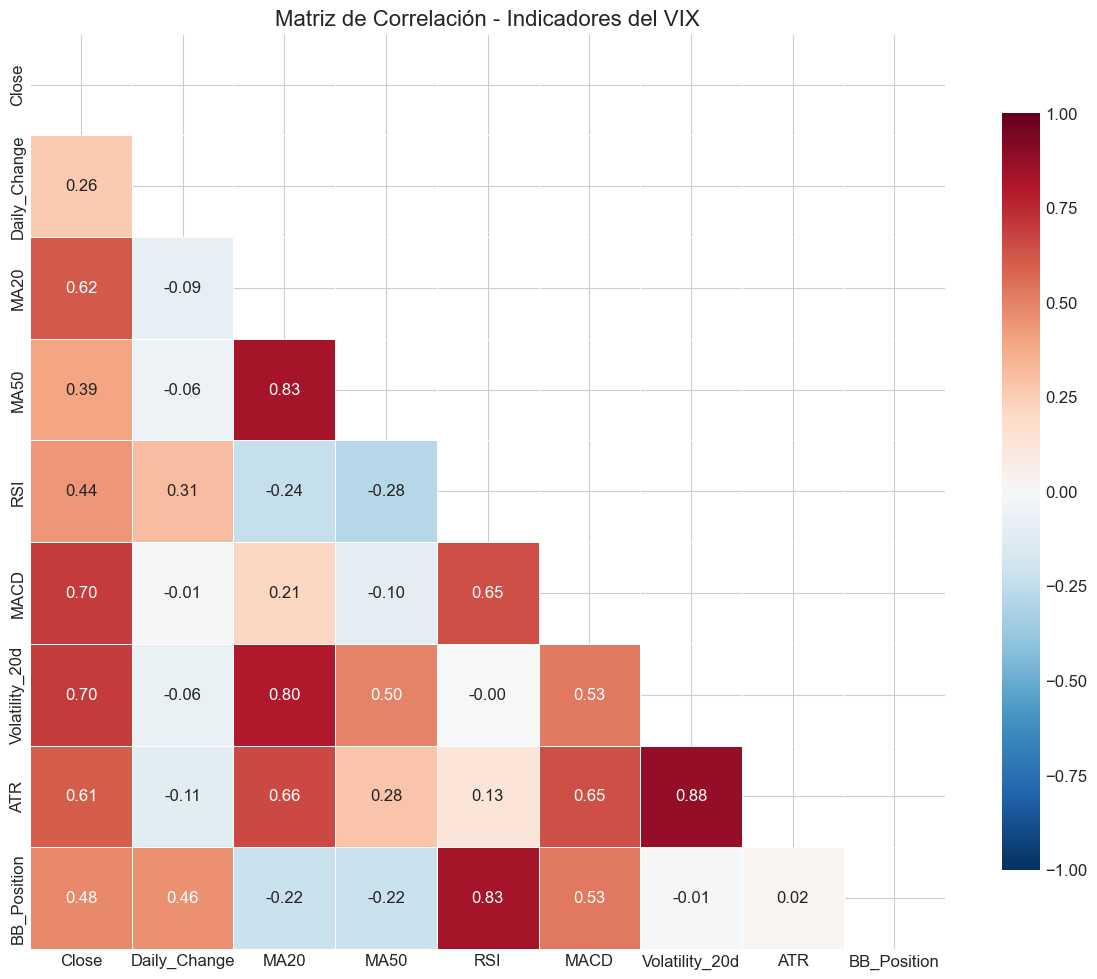


🔗 CORRELACIONES MÁS SIGNIFICATIVAS:

Correlaciones positivas más fuertes:
   Volatility_20d ↔ ATR: 0.881
   RSI ↔ BB_Position: 0.834
   MA20 ↔ MA50: 0.833
   MA20 ↔ Volatility_20d: 0.802
   Close ↔ MACD: 0.701

Correlaciones negativas más fuertes:


In [14]:
# ## 6. Análisis de Correlaciones

# %%
# Matriz de correlación detallada
if df is not None:
    # Seleccionar columnas numéricas relevantes
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Excluir columnas temporales básicas y lags para la correlación principal
    exclude_cols = ['Year', 'Month', 'Quarter', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear']
    correlation_cols = [col for col in numeric_cols if col not in exclude_cols and 'Lag' not in col]
    
    # Seleccionar las columnas más importantes
    important_cols = ['Close', 'Daily_Change', 'MA20', 'MA50', 'RSI', 'MACD', 
                      'Volatility_20d', 'ATR', 'BB_Position']
    correlation_cols = [col for col in important_cols if col in df.columns]
    
    if len(correlation_cols) > 2:
        # Calcular matriz de correlación
        corr_matrix = df[correlation_cols].corr()
        
        # Crear máscara para triángulo superior
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        # Crear figura
        plt.figure(figsize=(12, 10))
        
        # Mapa de calor
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                    cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                    square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
        
        plt.title('Matriz de Correlación - Indicadores del VIX', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Correlaciones más fuertes
        print("\n🔗 CORRELACIONES MÁS SIGNIFICATIVAS:")
        print("="*50)
        
        # Obtener correlaciones ordenadas
        corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_pairs.append({
                    'Variable 1': corr_matrix.columns[i],
                    'Variable 2': corr_matrix.columns[j],
                    'Correlación': corr_matrix.iloc[i, j]
                })
        
        corr_df = pd.DataFrame(corr_pairs)
        corr_df['Abs_Corr'] = corr_df['Correlación'].abs()
        corr_df = corr_df.sort_values('Abs_Corr', ascending=False)
        
        print("\nCorrelaciones positivas más fuertes:")
        positive_corr = corr_df[corr_df['Correlación'] > 0.5].head(5)
        for _, row in positive_corr.iterrows():
            print(f"   {row['Variable 1']} ↔ {row['Variable 2']}: {row['Correlación']:.3f}")
        
        print("\nCorrelaciones negativas más fuertes:")
        negative_corr = corr_df[corr_df['Correlación'] < -0.3].head(5)
        for _, row in negative_corr.iterrows():
            print(f"   {row['Variable 1']} ↔ {row['Variable 2']}: {row['Correlación']:.3f}")

🚨 EVENTOS EXTREMOS DETECTADOS:
Total de días extremos: 11 (4.4% del total)

📈 TOP 10 DÍAS CON VIX MÁS ALTO:
   2025-04-08: VIX = 52.33 (Cambio: 11.4%)
   2025-04-07: VIX = 46.98 (Cambio: 3.7%)
   2025-04-04: VIX = 45.31 (Cambio: 50.9%)
   2025-04-10: VIX = 40.72 (Cambio: 21.1%)
   2024-08-05: VIX = 38.57 (Cambio: 64.9%)
   2025-04-11: VIX = 37.56 (Cambio: -7.8%)
   2025-04-21: VIX = 33.82 (Cambio: 14.1%)
   2025-04-09: VIX = 33.62 (Cambio: -35.8%)
   2025-04-16: VIX = 32.64 (Cambio: 8.4%)
   2025-04-14: VIX = 30.89 (Cambio: -17.8%)

📊 MAYORES MOVIMIENTOS DIARIOS:

Mayores subidas:
   2024-12-18: +74.0% (VIX: 27.62)
   2024-08-05: +64.9% (VIX: 38.57)
   2025-04-04: +50.9% (VIX: 45.31)
   2025-04-03: +39.6% (VIX: 30.02)
   2024-09-03: +38.1% (VIX: 20.72)

Mayores caídas:
   2025-04-09: -35.8% (VIX: 33.62)
   2024-08-06: -28.2% (VIX: 27.71)
   2024-12-20: -23.8% (VIX: 18.36)
   2024-11-06: -20.6% (VIX: 16.27)
   2025-04-14: -17.8% (VIX: 30.89)


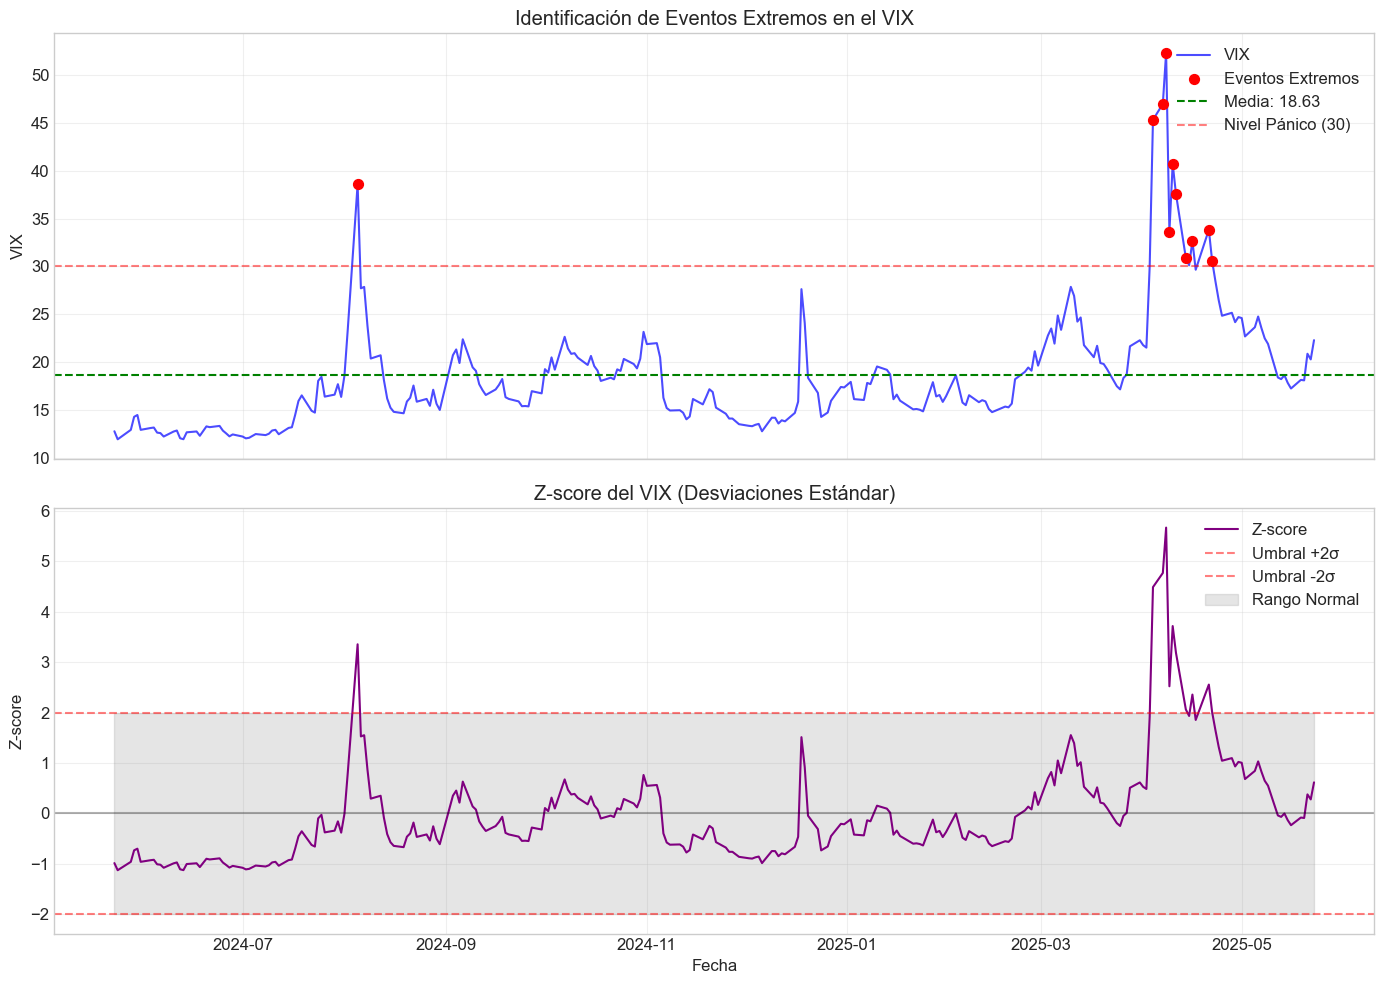

In [15]:
# ## 7. Detección de Anomalías y Eventos Extremos

# %%
# Identificar eventos extremos
if df is not None:
    # Calcular z-scores para identificar outliers
    df['Close_zscore'] = stats.zscore(df['Close'].dropna())
    
    # Identificar días extremos (z-score > 2)
    extreme_days = df[abs(df['Close_zscore']) > 2].copy()
    
    print("🚨 EVENTOS EXTREMOS DETECTADOS:")
    print("="*50)
    print(f"Total de días extremos: {len(extreme_days)} ({len(extreme_days)/len(df)*100:.1f}% del total)")
    
    # Top 10 días con VIX más alto
    print("\n📈 TOP 10 DÍAS CON VIX MÁS ALTO:")
    top_vix = df.nlargest(10, 'Close')[['Date', 'Close', 'Daily_Change', 'VIX_Level']]
    for idx, row in top_vix.iterrows():
        print(f"   {row['Date'].date()}: VIX = {row['Close']:.2f} (Cambio: {row['Daily_Change']:.1f}%)")
    
    # Mayores cambios diarios
    if 'Daily_Change' in df.columns:
        print("\n📊 MAYORES MOVIMIENTOS DIARIOS:")
        print("\nMayores subidas:")
        top_increases = df.nlargest(5, 'Daily_Change')[['Date', 'Close', 'Daily_Change']]
        for idx, row in top_increases.iterrows():
            print(f"   {row['Date'].date()}: +{row['Daily_Change']:.1f}% (VIX: {row['Close']:.2f})")
        
        print("\nMayores caídas:")
        top_decreases = df.nsmallest(5, 'Daily_Change')[['Date', 'Close', 'Daily_Change']]
        for idx, row in top_decreases.iterrows():
            print(f"   {row['Date'].date()}: {row['Daily_Change']:.1f}% (VIX: {row['Close']:.2f})")
    
    # Visualización de eventos extremos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Panel superior: VIX con eventos extremos marcados
    ax1.plot(df['Date'], df['Close'], label='VIX', color='blue', alpha=0.7)
    ax1.scatter(extreme_days['Date'], extreme_days['Close'], 
                color='red', s=50, label='Eventos Extremos', zorder=5)
    ax1.axhline(y=df['Close'].mean(), color='green', linestyle='--', 
                label=f'Media: {df["Close"].mean():.2f}')
    ax1.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='Nivel Pánico (30)')
    ax1.set_ylabel('VIX')
    ax1.set_title('Identificación de Eventos Extremos en el VIX')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Panel inferior: Z-score
    ax2.plot(df['Date'], df['Close_zscore'], label='Z-score', color='purple')
    ax2.axhline(y=2, color='red', linestyle='--', alpha=0.5, label='Umbral +2σ')
    ax2.axhline(y=-2, color='red', linestyle='--', alpha=0.5, label='Umbral -2σ')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.fill_between(df['Date'], -2, 2, alpha=0.2, color='gray', label='Rango Normal')
    ax2.set_ylabel('Z-score')
    ax2.set_xlabel('Fecha')
    ax2.set_title('Z-score del VIX (Desviaciones Estándar)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [24]:
# ## 8. Preparación de Datos para Dashboard

# %%
# Crear resumen de KPIs para dashboard
if df is not None:
    # Calcular todos los KPIs necesarios
    current_date = df['Date'].max()
    
    kpis = {
        # KPIs Principales
        'fecha_actual': current_date.strftime('%Y-%m-%d'),
        'vix_actual': df['Close'].iloc[-1],
        'cambio_diario_pct': df['Daily_Change'].iloc[-1] if 'Daily_Change' in df.columns else 0,
        'cambio_diario_pts': df['Close'].iloc[-1] - df['Close'].iloc[-2] if len(df) > 1 else 0,
        
        # Medias Móviles
        'ma20': df['MA20'].iloc[-1] if 'MA20' in df.columns else None,
        'ma50': df['MA50'].iloc[-1] if 'MA50' in df.columns else None,
        
        # Indicadores Técnicos
        'rsi': df['RSI'].iloc[-1] if 'RSI' in df.columns else None,
        'macd': df['MACD'].iloc[-1] if 'MACD' in df.columns else None,
        'atr': df['ATR'].iloc[-1] if 'ATR' in df.columns else None,
        
        # Volatilidad
        'volatilidad_20d': df['Volatility_20d'].iloc[-1] if 'Volatility_20d' in df.columns else None,
        'volatilidad_10d': df['Volatility_10d'].iloc[-1] if 'Volatility_10d' in df.columns else None,
        
        # Niveles
        'nivel_actual': df['VIX_Level'].iloc[-1] if 'VIX_Level' in df.columns else 'Normal',
        'bb_position': df['BB_Position'].iloc[-1] if 'BB_Position' in df.columns else None,
        
        # Estadísticas del período
        'max_30d': df['Close'].tail(30).max(),
        'min_30d': df['Close'].tail(30).min(),
        'promedio_30d': df['Close'].tail(30).mean(),
        'max_ytd': df[df['Date'] >= f"{current_date.year}-01-01"]['Close'].max() if len(df[df['Date'] >= f"{current_date.year}-01-01"]) > 0 else None,
        'min_ytd': df[df['Date'] >= f"{current_date.year}-01-01"]['Close'].min() if len(df[df['Date'] >= f"{current_date.year}-01-01"]) > 0 else None,
        
        # Retornos
        'retorno_semanal': ((df['Close'].iloc[-1] / df['Close'].iloc[-5] - 1) * 100) if len(df) >= 5 else None,
        'retorno_mensual': ((df['Close'].iloc[-1] / df['Close'].iloc[-22] - 1) * 100) if len(df) >= 22 else None,
        'retorno_trimestral': ((df['Close'].iloc[-1] / df['Close'].iloc[-66] - 1) * 100) if len(df) >= 66 else None,
        
        # Conteos
        'dias_sobre_20': len(df[df['Close'] > 20]),
        'dias_sobre_30': len(df[df['Close'] > 30]),
        'total_dias': len(df)
    }
    
    # Crear DataFrame de KPIs
    kpis_df = pd.DataFrame([kpis])
    
    print("📊 RESUMEN DE KPIs PARA DASHBOARD:")
    print("="*50)
    print(f"\n1. VALORES ACTUALES:")
    print(f"   VIX: {kpis['vix_actual']:.2f}")
    print(f"   Cambio: {kpis['cambio_diario_pct']:.2f}% ({kpis['cambio_diario_pts']:+.2f} pts)")
    print(f"   Nivel: {kpis['nivel_actual']}")
    
    print(f"\n2. INDICADORES TÉCNICOS:")
    print(f"   RSI: {kpis['rsi']:.1f}" if kpis['rsi'] else "   RSI: N/A")
    print(f"   MA20: {kpis['ma20']:.2f}" if kpis['ma20'] else "   MA20: N/A")
    print(f"   Volatilidad 20d: {kpis['volatilidad_20d']:.2f}" if kpis['volatilidad_20d'] else "   Volatilidad 20d: N/A")
    
    print(f"\n3. RENDIMIENTO:")
    print(f"   Semanal: {kpis['retorno_semanal']:.1f}%" if kpis['retorno_semanal'] else "   Semanal: N/A")
    print(f"   Mensual: {kpis['retorno_mensual']:.1f}%" if kpis['retorno_mensual'] else "   Mensual: N/A")
    print(f"   Trimestral: {kpis['retorno_trimestral']:.1f}%" if kpis['retorno_trimestral'] else "   Trimestral: N/A")
    
    # Guardar KPIs para uso posterior
    kpis_df.to_csv('static/data/vix_kpis_summary.csv', index=False)
    print("\n✅ KPIs guardados en: static/data/vix_kpis_summary.csv")

TypeError: '>=' not supported between instances of 'Timestamp' and 'str'

📈 ANÁLISIS DE SEÑALES TÉCNICAS:

1. CRUCES DE MEDIAS MÓVILES:
   Cruces dorados (alcistas): 3
   Cruces de muerte (bajistas): 4

   Últimos cruces dorados:
      2024-10-15: VIX = 20.64
      2025-01-07: VIX = 17.82
      2025-03-03: VIX = 22.78

2. SEÑAL RSI ACTUAL: Neutral (RSI = 45.7)

3. BANDAS DE BOLLINGER: En rango medio (Posición: 0.58)

4. SEÑALES MACD:
   Cruces alcistas: 12
   Cruces bajistas: 12
   Estado actual: Alcista


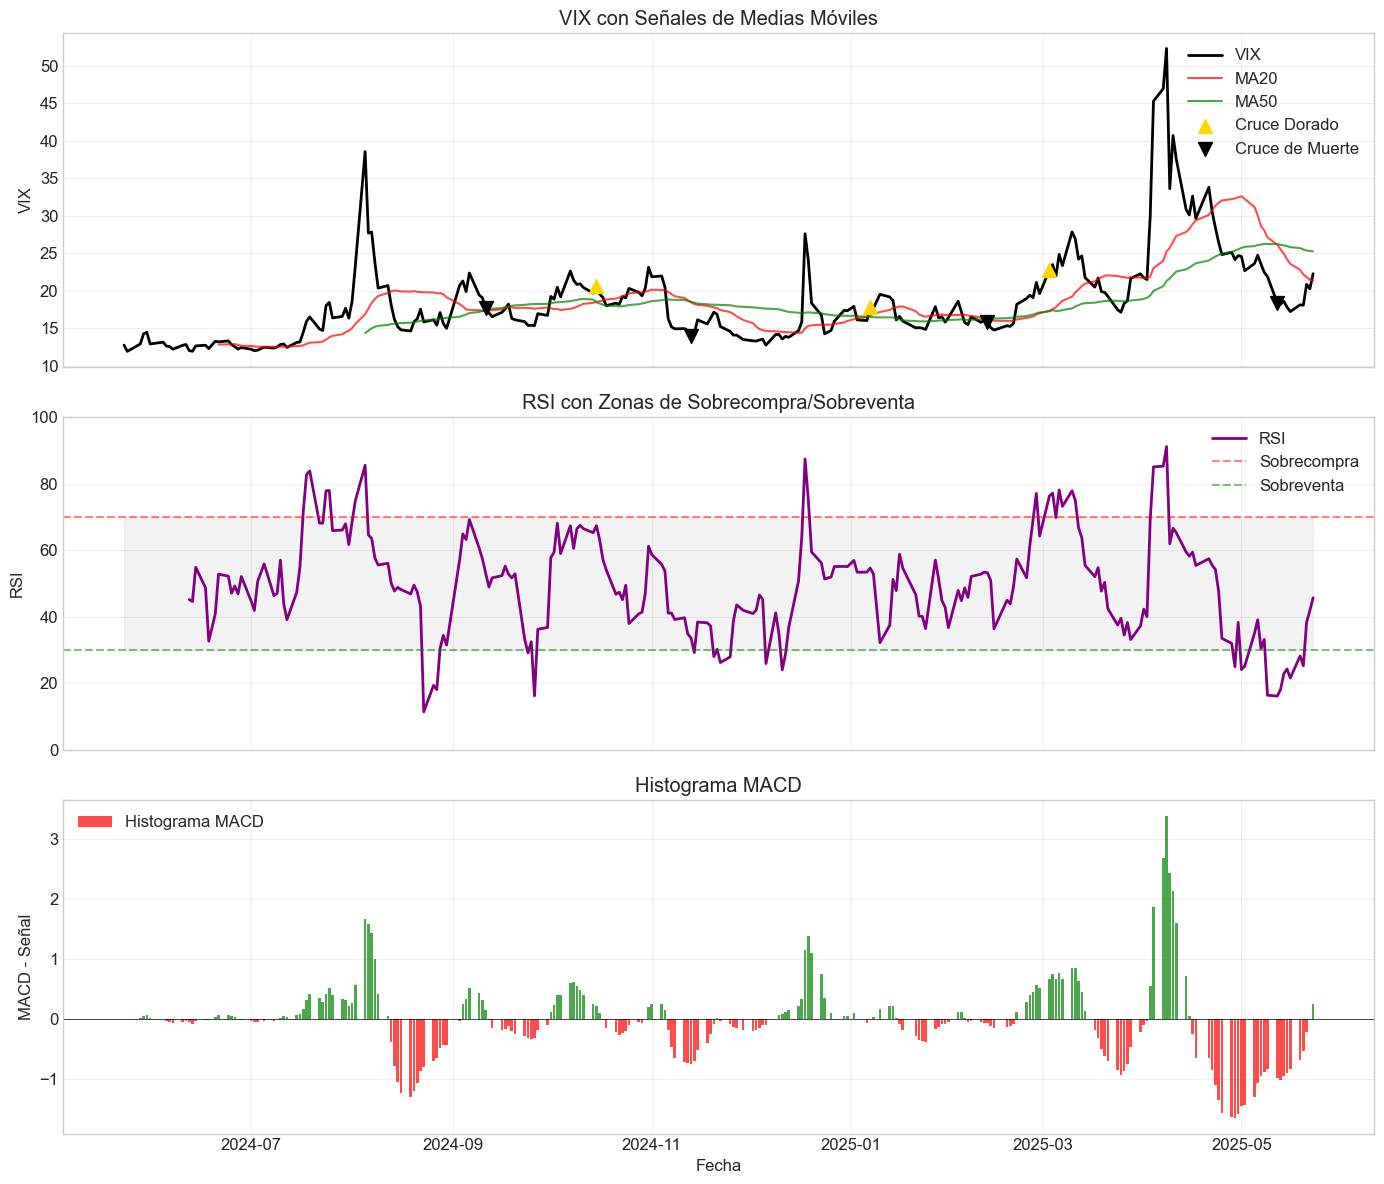

In [19]:
# ## 9. Análisis de Tendencias y Señales

# %%
# Identificar señales de trading técnico
if df is not None:
    print("📈 ANÁLISIS DE SEÑALES TÉCNICAS:")
    print("="*50)
    
    # Crear DataFrame para señales
    signals = pd.DataFrame(index=df.index)
    signals['Date'] = df['Date']
    signals['Close'] = df['Close']
    
    # 1. Cruces de medias móviles
    if all(col in df.columns for col in ['MA20', 'MA50']):
        signals['MA_Signal'] = 0
        signals.loc[df['MA20'] > df['MA50'], 'MA_Signal'] = 1  # Señal alcista
        signals.loc[df['MA20'] < df['MA50'], 'MA_Signal'] = -1  # Señal bajista
        
        # Detectar cruces
        signals['MA_Cross'] = signals['MA_Signal'].diff()
        golden_crosses = signals[signals['MA_Cross'] == 2]  # Cruce dorado
        death_crosses = signals[signals['MA_Cross'] == -2]  # Cruce de muerte
        
        print("\n1. CRUCES DE MEDIAS MÓVILES:")
        print(f"   Cruces dorados (alcistas): {len(golden_crosses)}")
        print(f"   Cruces de muerte (bajistas): {len(death_crosses)}")
        
        if len(golden_crosses) > 0:
            print("\n   Últimos cruces dorados:")
            for idx, row in golden_crosses.tail(3).iterrows():
                print(f"      {row['Date'].date()}: VIX = {row['Close']:.2f}")
    
    # 2. Señales RSI
    if 'RSI' in df.columns:
        signals['RSI_Signal'] = 'Neutral'
        signals.loc[df['RSI'] > 70, 'RSI_Signal'] = 'Sobrecompra'
        signals.loc[df['RSI'] < 30, 'RSI_Signal'] = 'Sobreventa'
        
        rsi_current = df['RSI'].iloc[-1]
        print(f"\n2. SEÑAL RSI ACTUAL: {signals['RSI_Signal'].iloc[-1]} (RSI = {rsi_current:.1f})")
    
    # 3. Posición en Bandas de Bollinger
    if 'BB_Position' in df.columns:
        bb_position = df['BB_Position'].iloc[-1]
        if bb_position > 0.8:
            bb_signal = "Cerca de banda superior (posible reversión bajista)"
        elif bb_position < 0.2:
            bb_signal = "Cerca de banda inferior (posible reversión alcista)"
        else:
            bb_signal = "En rango medio"
        
        print(f"\n3. BANDAS DE BOLLINGER: {bb_signal} (Posición: {bb_position:.2f})")
    
    # 4. Divergencias MACD
    if all(col in df.columns for col in ['MACD', 'MACD_Signal']):
        signals['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
        signals['MACD_Cross'] = 0
        signals.loc[signals['MACD_Histogram'] > 0, 'MACD_Cross'] = 1
        signals.loc[signals['MACD_Histogram'] < 0, 'MACD_Cross'] = -1
        
        macd_changes = signals['MACD_Cross'].diff()
        bullish_macd = len(macd_changes[macd_changes == 2])
        bearish_macd = len(macd_changes[macd_changes == -2])
        
        print(f"\n4. SEÑALES MACD:")
        print(f"   Cruces alcistas: {bullish_macd}")
        print(f"   Cruces bajistas: {bearish_macd}")
        print(f"   Estado actual: {'Alcista' if signals['MACD_Cross'].iloc[-1] == 1 else 'Bajista'}")
    
    # Visualización de señales
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # Panel 1: Precio con señales de MA
    ax1 = axes[0]
    ax1.plot(df['Date'], df['Close'], label='VIX', color='black', linewidth=2)
    if 'MA20' in df.columns:
        ax1.plot(df['Date'], df['MA20'], label='MA20', color='red', alpha=0.7)
    if 'MA50' in df.columns:
        ax1.plot(df['Date'], df['MA50'], label='MA50', color='green', alpha=0.7)
    
    # Marcar cruces
    if 'MA_Cross' in signals.columns:
        golden = signals[signals['MA_Cross'] == 2]
        death = signals[signals['MA_Cross'] == -2]
        ax1.scatter(golden['Date'], golden['Close'], color='gold', s=100, 
                   marker='^', label='Cruce Dorado', zorder=5)
        ax1.scatter(death['Date'], death['Close'], color='black', s=100, 
                   marker='v', label='Cruce de Muerte', zorder=5)
    
    ax1.set_title('VIX con Señales de Medias Móviles')
    ax1.set_ylabel('VIX')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: RSI con zonas
    if 'RSI' in df.columns:
        ax2 = axes[1]
        ax2.plot(df['Date'], df['RSI'], label='RSI', color='purple', linewidth=2)
        ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Sobrecompra')
        ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Sobreventa')
        ax2.fill_between(df['Date'], 30, 70, alpha=0.1, color='gray')
        ax2.set_title('RSI con Zonas de Sobrecompra/Sobreventa')
        ax2.set_ylabel('RSI')
        ax2.set_ylim(0, 100)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Panel 3: MACD
    if 'MACD_Histogram' in signals.columns:
        ax3 = axes[2]
        colors = ['green' if x > 0 else 'red' for x in signals['MACD_Histogram']]
        ax3.bar(df['Date'], signals['MACD_Histogram'], color=colors, alpha=0.7, label='Histograma MACD')
        ax3.axhline(y=0, color='black', linewidth=0.5)
        ax3.set_title('Histograma MACD')
        ax3.set_ylabel('MACD - Señal')
        ax3.set_xlabel('Fecha')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [20]:
# ## 10. Exportación de Resultados y Reportes

# %%
# Generar reporte completo
if df is not None:
    # Crear diccionario con todos los análisis
    report = {
        'fecha_reporte': datetime.now().strftime('%Y-%m-%d %H:%M'),
        'periodo_datos': f"{df['Date'].min().date()} a {df['Date'].max().date()}",
        'total_registros': len(df),
        
        # Estadísticas básicas
        'estadisticas_basicas': {
            'vix_promedio': df['Close'].mean(),
            'vix_mediana': df['Close'].median(),
            'vix_std': df['Close'].std(),
            'vix_min': df['Close'].min(),
            'vix_max': df['Close'].max(),
            'vix_actual': df['Close'].iloc[-1]
        },
        
        # Niveles de riesgo
        'distribucion_niveles': df['VIX_Level'].value_counts().to_dict() if 'VIX_Level' in df.columns else {},
        
        # Indicadores técnicos actuales
        'indicadores_actuales': {
            'rsi': df['RSI'].iloc[-1] if 'RSI' in df.columns else None,
            'ma20': df['MA20'].iloc[-1] if 'MA20' in df.columns else None,
            'ma50': df['MA50'].iloc[-1] if 'MA50' in df.columns else None,
            'volatilidad_20d': df['Volatility_20d'].iloc[-1] if 'Volatility_20d' in df.columns else None
        },
        
        # Retornos
        'retornos': {
            'diario': kpis['cambio_diario_pct'] if 'kpis' in locals() else None,
            'semanal': kpis['retorno_semanal'] if 'kpis' in locals() else None,
            'mensual': kpis['retorno_mensual'] if 'kpis' in locals() else None
        }
    }
    
    # Guardar reporte en JSON
    import json
    with open('static/data/vix_analysis_report.json', 'w') as f:
        json.dump(report, f, indent=2, default=str)
    
    print("\n📊 REPORTE FINAL GENERADO:")
    print("="*50)
    print(f"Fecha del reporte: {report['fecha_reporte']}")
    print(f"Período analizado: {report['periodo_datos']}")
    print(f"Total de registros: {report['total_registros']:,}")
    print("\n✅ Archivos generados:")
    print("   - static/data/vix_kpis_summary.csv")
    print("   - static/data/vix_recent_data.csv")
    print("   - static/data/vix_analysis_report.json")
    
    # Crear DataFrame resumen para Power BI
    powerbi_summary = pd.DataFrame({
        'Métrica': ['VIX Actual', 'Cambio Diario %', 'MA20', 'MA50', 'RSI', 
                    'Volatilidad 20d', 'Nivel', 'Max 30d', 'Min 30d'],
        'Valor': [
            df['Close'].iloc[-1],
            kpis['cambio_diario_pct'] if 'kpis' in locals() else 0,
            df['MA20'].iloc[-1] if 'MA20' in df.columns else 0,
            df['MA50'].iloc[-1] if 'MA50' in df.columns else 0,
            df['RSI'].iloc[-1] if 'RSI' in df.columns else 0,
            df['Volatility_20d'].iloc[-1] if 'Volatility_20d' in df.columns else 0,
            df['VIX_Level'].iloc[-1] if 'VIX_Level' in df.columns else 'Normal',
            df['Close'].tail(30).max(),
            df['Close'].tail(30).min()
        ]
    })
    
    powerbi_summary.to_csv('static/data/powerbi_metrics_summary.csv', index=False)
    print("   - static/data/powerbi_metrics_summary.csv")
    
    print("\n💡 PRÓXIMOS PASOS:")
    print("1. Importar los archivos CSV en Power BI")
    print("2. Crear las visualizaciones según la guía proporcionada")
    print("3. Configurar actualización automática de datos")
    print("4. Publicar el dashboard en Power BI Service")


📊 REPORTE FINAL GENERADO:
Fecha del reporte: 2025-05-25 14:38
Período analizado: 2024-05-23 a 2025-05-23
Total de registros: 251

✅ Archivos generados:
   - static/data/vix_kpis_summary.csv
   - static/data/vix_recent_data.csv
   - static/data/vix_analysis_report.json
   - static/data/powerbi_metrics_summary.csv

💡 PRÓXIMOS PASOS:
1. Importar los archivos CSV en Power BI
2. Crear las visualizaciones según la guía proporcionada
3. Configurar actualización automática de datos
4. Publicar el dashboard en Power BI Service
